In [17]:
import sklearn
import numpy as np
from tensorflow import keras
from explainer.metrics import draw_network
from pgmpy.utils import get_example_model

# DATA

  0%|          | 0/8 [00:00<?, ?it/s]

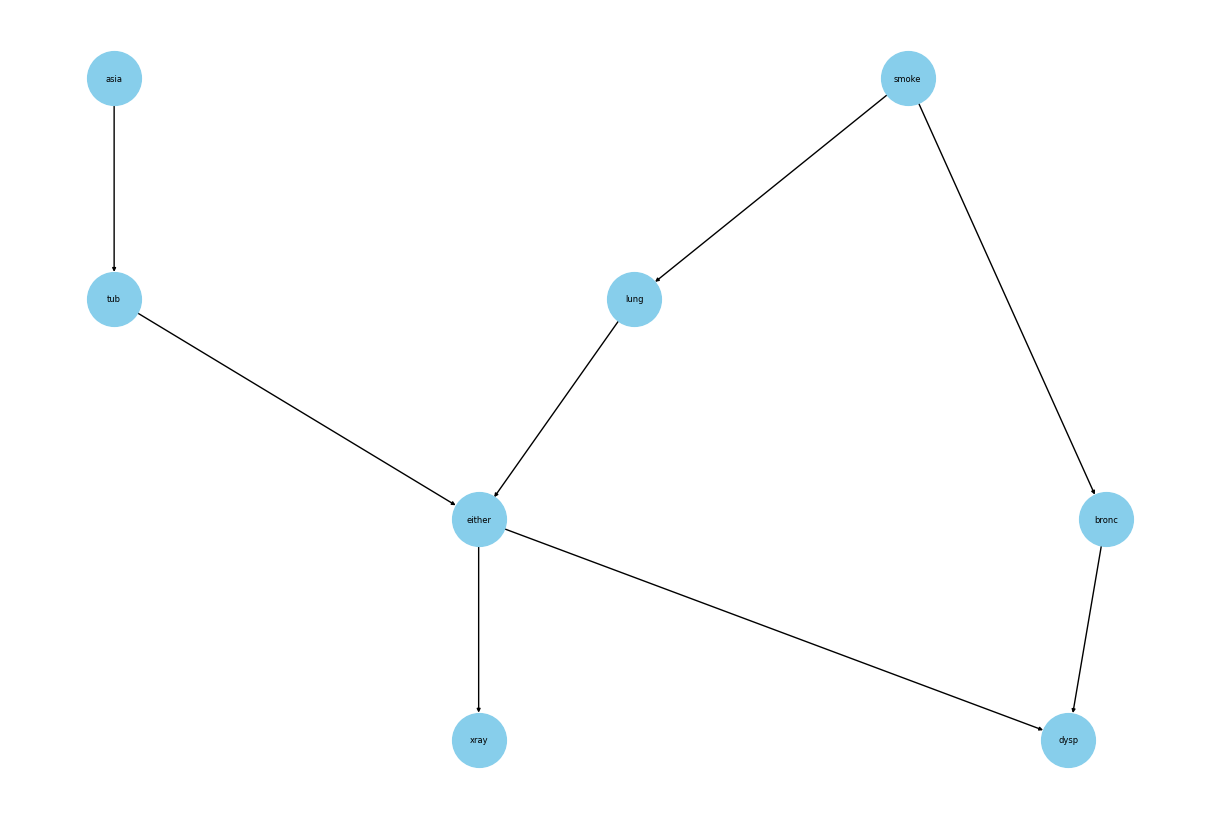

In [394]:
ground_bn = get_example_model("asia")
dataset = ground_bn.simulate(n_samples = 1000)
draw_network(ground_bn)

In [3]:
from ucimlrepo import fetch_ucirepo 
  
car_evaluation = fetch_ucirepo(id = 19)

X = car_evaluation.data.features.to_numpy()
y = car_evaluation.data.targets.to_numpy()

In [395]:
target = 'bronc'

X = dataset.drop(target, axis = 1).to_numpy()
y = dataset[target].to_numpy()

In [396]:
dataset[target].unique()

['no', 'yes']
Categories (2, object): ['no', 'yes']

In [397]:
len(dataset[dataset[target] == 'no'])

564

In [398]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size = 0.1, random_state = 23, shuffle = True
)

In [399]:
feature_encoder = sklearn.preprocessing.OrdinalEncoder()
feature_encoder.fit(X_train)

target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(y_train.squeeze())

def preprocessor(x):
    return feature_encoder.transform(x)

In [400]:
X_train_proc = feature_encoder.transform(X_train)
y_train_proc = target_encoder.transform(y_train)

In [401]:
n_classes = len(np.unique(y))
input_shape = len(X[0])

print(f'Number of classes: {n_classes}')
print(f'Input Shape: {input_shape}')

Number of classes: 2
Input Shape: 7


# MODEL

In [402]:
def build_model(input_shape, classes, n_layers = 5, n_nodes_l = 2, n_nodes_u = 10, optimizer = 'adam', learning_rate = 0.001):
    
    model = keras.Sequential()
    model.add(keras.Input(shape = (input_shape,)))
    for i in range(n_layers):
        model.add(keras.layers.Dense(np.random.choice([i for i in range(n_nodes_l, n_nodes_u)]), activation = np.random.choice(['relu', 'sigmoid'])))
    model.add(keras.layers.Dense(classes, activation = 'softmax'))

    if optimizer == 'sgd':
        optim = keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'adam':
        optim = keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model



In [403]:
n_layers = 5
n_nodes_l = 5
n_nodes_u = 50
optimizer = 'adam'
learning_rate = 0.01
epochs = 25
batch_size = 64

In [404]:
model = build_model(
    input_shape,
    n_classes,
    n_layers = n_layers, 
    n_nodes_l = n_nodes_l,
    n_nodes_u = n_nodes_u, 
    optimizer = optimizer, 
    learning_rate = learning_rate
)

'''
config = wandb.config
config.n_layers = n_layers
config.n_nodes_l = n_nodes_l
config.n_nodes_u = n_nodes_u
config.optimizer = optimizer
config.epochs = epochs
config.batch_size = batch_size
config.learning_rate = learning_rate
'''

model.fit(X_train_proc, y_train_proc, epochs = epochs, batch_size = batch_size, validation_split = 0.2)
model.summary()

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5528 - loss: 0.6828 - val_accuracy: 0.4944 - val_loss: 0.6888
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6861 - loss: 0.6005 - val_accuracy: 0.8167 - val_loss: 0.4958
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8014 - loss: 0.4523 - val_accuracy: 0.8222 - val_loss: 0.5504
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8528 - loss: 0.4070 - val_accuracy: 0.8278 - val_loss: 0.4499
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8528 - loss: 0.3978 - val_accuracy: 0.8333 - val_loss: 0.4376
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8583 - loss: 0.3930 - val_accuracy: 0.8333 - val_loss: 0.4618
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8583 - loss: 0.3925 - val_accuracy: 0.8333 - val_loss: 0.4462
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8444 - loss: 0.3913 - val_accuracy: 0.8333 - val_loss

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 31)             │           248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 28)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 9)              │           261 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 43)             │           430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │            88 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,939 (23.20 KB)

 Trainable params: 1,979 (7.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,960 (15.47 KB)

In [405]:
X_test_proc = feature_encoder.transform(X_test)
y_test_proc = target_encoder.transform(y_test)

y_pred = model(X_test_proc)
y_pred = np.argmax(y_pred, axis = 1)
sklearn.metrics.accuracy_score(y_pred, y_test_proc)

0.91

# INFINITE TSUKI NO ME

In [406]:
import itertools
import numpy as np
import pandas as pd
from pgmpy.base import PDAG
from pgmpy.estimators import PC, HillClimbSearch, ExpertKnowledge
from mlxtend.frequent_patterns import fpgrowth, association_rules

In [407]:
class Explainer:
    
    def __init__(self, model, X, target, preprocessor, n_samples = 100, rep_prob = 0.5):
        
        self.X = X.to_numpy()
        
        self.x_cols = X.columns
        self.y_col = target
        
        self.model = model
        self.preprocessor = preprocessor
        
        self.n_samples = n_samples
        self.rep_prob = rep_prob
        
        
        self.associations = []
        self.patterns = []
        self.data = None
        
        self.dag = None
        self.pdag = None
        
    def data_generation(self, x):
        
        y = self.model.predict(self.preprocessor(x.reshape(1, -1)), verbose = 0).squeeze(0)
        y_argmax = y.argmax()
        
        random_indices = np.random.randint(len(self.X), size = self.n_samples)
        samples_X_base = self.X[random_indices]
        
        replace_mask = np.random.rand(self.n_samples, samples_X_base.shape[1]) < self.rep_prob
        
        samples_X_generated = np.where(replace_mask, x, samples_X_base)
        
        preprocessed_batch = self.preprocessor(samples_X_generated)
        
        samples_Y_raw = self.model.predict(preprocessed_batch, verbose = 0)
        
        samples_Y_argmax = samples_Y_raw.argmax(axis = 1)
        
        samples_Y_bool = samples_Y_argmax != y_argmax
        
        samples_X_bool = samples_X_generated != x
        
        samples_X_int = samples_X_bool.astype(int)
        samples_Y_int = samples_Y_bool.astype(int)
        
        self.data = pd.DataFrame(samples_X_int, columns = self.x_cols)
        self.data[self.y_col] = samples_Y_int

    def fp_growth(self, min_support, min_threshold, class_):

        data = self.data[self.data[self.y_col] == class_].drop(self.y_col, axis = 1)
        
        for col in data.columns:

            data[f'{col}_stable'] = 1 - data[col]
            data = data.rename(columns = {col: f'{col}_unstable'})

        data = data.astype(bool)
        
        patterns = fpgrowth(data, min_support = min_support, use_colnames = True)
        associations = association_rules(patterns, metric = "confidence", min_threshold = min_threshold)

        self.patterns.append(patterns)
        self.associations.append(associations[['antecedents', 'consequents', 'support', 'confidence']])
        
    def explain(self, x, min_support, min_threshold):
        
        self.data_generation(x)

        for class_ in [0, 1]:

            self.fp_growth(min_support, min_threshold, class_)

In [418]:
explainer = Explainer(model, dataset.drop(target, axis = 1), target, preprocessor, n_samples = 1000, rep_prob = 0.1)
x = X_test[np.random.randint(len(X_test))]

In [419]:
explainer.explain(x, 0.1, 0.01)

In [420]:
explainer.patterns[0].sort_values(by = "support", ascending = False).head(20)

,support,itemsets
0,0.997863,(dysp_stable)
1,0.993590,(tub_stable)
9,0.991453,"(dysp_stable, tub_stable)"
2,0.976496,(asia_stable)
10,0.974359,"(dysp_stable, asia_stable)"
11,0.970085,"(asia_stable, tub_stable)"
12,0.967949,"(dysp_stable, asia_stable, tub_stable)"
3,0.957265,(either_stable)
13,0.955128,"(tub_stable, either_stable)"
14,0.955128,"(dysp_stable, either_stable)"


In [421]:
explainer.patterns[1].sort_values(by = "support", ascending = False).head(20)

,support,itemsets
0,0.988722,(tub_stable)
1,0.981203,(dysp_unstable)
8,0.981203,"(dysp_unstable, tub_stable)"
2,0.979323,(asia_stable)
3,0.975564,(lung_stable)
9,0.968045,"(asia_stable, tub_stable)"
12,0.964286,"(lung_stable, tub_stable)"
10,0.960526,"(dysp_unstable, asia_stable)"
11,0.960526,"(dysp_unstable, asia_stable, tub_stable)"
13,0.958647,"(dysp_unstable, lung_stable)"
